In [29]:
from utility import InterpretCfg, load_model, interpret, give_caption, FeatureExtractor
from PIL import Image
import torch
from wordcloud import WordCloud

In [14]:
# interpretation config
config = InterpretCfg(
        seq_len=30,
        max_seq_len=77,
        temperature=1.0,
        generation_type="top_k",
        top_k=1,
        repetition_penalty=1.0,
        model_name="coca_ViT-L-14",
        pretrained="mscoco_finetuned_laion2B-s13B-b90k",
        keep_probs=False
    )

In [15]:
# Loading the model (CoCa, from: https://github.com/mlfoundations/open_clip)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_components = load_model(config, device)

2025-01-08 18:02:43,120 | INFO | Loading model coca_ViT-L-14 with pretrained weights mscoco_finetuned_laion2B-s13B-b90k on cuda...
2025-01-08 18:02:43,123 | INFO | Loaded coca_ViT-L-14 model config.
2025-01-08 18:02:48,956 | INFO | Loading pretrained coca_ViT-L-14 weights (mscoco_finetuned_laion2B-s13B-b90k).
/home/shaghighat/miniforge3/envs/interpret/lib/python3.10/site-packages/open_clip/factory.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expli

In [16]:
model_components.keys()

dict_keys(['model', 'multimodal_decoder', 'visual', 'text_encoder', 'att_pooler_ln', 'text_decoder', 'coca_vocab', 'transform'])

In [17]:
model_components['visual'].transformer.resblocks

ModuleList(
  (0-23): 24 x ResidualAttentionBlock(
    (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
    )
    (ls_1): Identity()
    (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
      (gelu): GELU(approximate='none')
      (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
    )
    (ls_2): Identity()
  )
)

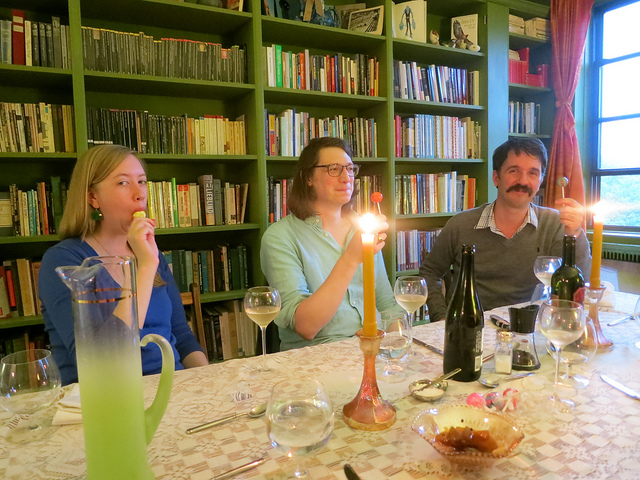

In [30]:
# Visualizing the test image
img = '../data/COCO_val2014_000000560744.jpg'
im = Image.open(img).convert("RGB")
im = model_components['transform'](im).unsqueeze(0).to('cuda')

from IPython.display import Image as display
display(img)

In [31]:
# Generating captions after every layer of the vision encoder: 
for i in range(24):
    transformer_features = FeatureExtractor(model_components['visual'], layer_name=f'transformer.resblocks.{i}') 
    features = transformer_features.extract_features(im)
    input_visual_features = features.permute(1,0,2) #this is to match the dim received by attn_pooler
    batched_token_ids, _, _ = interpret(
                        features=input_visual_features,
                        config=config,
                        vision_encoder=model_components["att_pooler_ln"],
                        text_encoder=model_components["text_encoder"],
                        multimodal_decoder=model_components["multimodal_decoder"],
                        vocab=model_components["coca_vocab"],
                        text_decoder=model_components["text_decoder"])
    print(f"layer {i+1}:", give_caption(batched_token_ids[0], text_decoder=model_components['text_decoder']))
    

layer 1: red red red and red gold red red and red red red red red red red orange red red red red red red red orange red red red
layer 2: gold gold gold orange gold red gold orange gold gold gold orange gold gold orange gold red gold gold orange gold gold red gold orange gold gold orange
layer 3: gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold
layer 4: gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold gold
layer 5: gold circle gold circle 's gold tan gold circle 's gold tan gold circle 's gold tan gold circle 's gold tan gold circle 's gold tan gold
layer 6: a gold circle with gold tan gold circle with gold tan gold circle featuring gold tan chicken , featuring gold tan tan gold circle with gold tan circle
layer 7: a gold circle with gold fgugold rgg land gycrab elvia set for a gold circle with gold fguland circl